# Probabilistic Graph Model: Bayesian Network

Making inference on 'crime against property' data

### Context

The data set is a 5-year record of reported Robbery & Theft within Manila from 2010 - 2014. The idea is to leverage on its intrinsic probability distribution on selected discrete variables. The goal is to infer on future probable density of robbery & theft happening.

In [ ]:
!pip install --upgrade pixiedust # for visualization/EDA, check documentation: https://pixiedust.github.io/pixiedust/displayapi.html
!pip install --upgrade pgmpy #for probabilistic graphical models, check documentations: https://github.com/pgmpy/pgmpy_notebook/blob/master/pdfs/Probabilistic%20Graphical%20Models%20using%20pgmpy.pdf
!pip install pyspark # for pixiedust data import and data manip
!pip install pandas_profiling # for quick dataset profiling/ EDA

In [2]:
# The code was removed by Watson Studio for sharing.

## Data pre-processing

In [3]:
#pre-req: pandas read data to df_data
from pandas.api.types import CategoricalDtype
import calendar

df_data['record_counter'] = 1

df_data['date']= pd.to_datetime(df_data['date'], format='%d/%m/%Y' )
df_data['time_of_crime'] = pd.to_datetime(df_data['time_of_crime'],format= '%I:%M:%S %p' ).dt.time
df_data['date'] = df_data.apply(lambda r : pd.datetime.combine(r['date'],r['time_of_crime']),1)

df_data['month'] = df_data.date.dt.month
df_data['month'] = df_data.month.apply(lambda x: calendar.month_abbr[x])

month_order = CategoricalDtype(categories=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                               ordered = True)
day_order = CategoricalDtype(categories=["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"],
                               ordered = True)
time_range_order = CategoricalDtype(categories=["12 AM - 3 AM", "3 AM - 6 AM", "6 AM - 9 AM", "9 AM - 12 PM", "12 PM - 3 PM", "3 PM - 6 PM", "6 PM - 9 PM", "9 PM - 12 AM"],
                               ordered = True)

df_data.month = df_data.month.astype(month_order)
df_data.day_of_week = df_data.day_of_week.astype(day_order)
df_data.time_range = df_data.time_range.astype(time_range_order)

df_data.week_of_month = ('week' + df_data.week_of_month.astype(str)).astype('category')

df_data.loc[:, df_data.dtypes == object] = df_data.loc[:, df_data.dtypes == object].astype(str)

#### Dataset Profiling

In [4]:
import pandas_profiling

In [6]:
profile = pandas_profiling.ProfileReport(df_data)
display(profile)

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: Us

## Exploratory Data Analysis

Visualizations

In [7]:
from pyspark.sql import SQLContext
from pyspark import SparkContext

sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

sdf = sqlContext.createDataFrame(df_data)
display(sdf)

DataFrame[date: timestamp, week_of_month: string, month: string, day_of_week: string, time_of_crime: string, time_range: string, crime_location: string, crime_type: string, property_loss: string, victim_occupation: string, victim_age: double, victim_civilstatus: string, victim_gender: string, suspect_count: bigint, suspect_weapon: string, suspect_gender: string, suspect_age: string, suspect_address: string, record_counter: bigint]


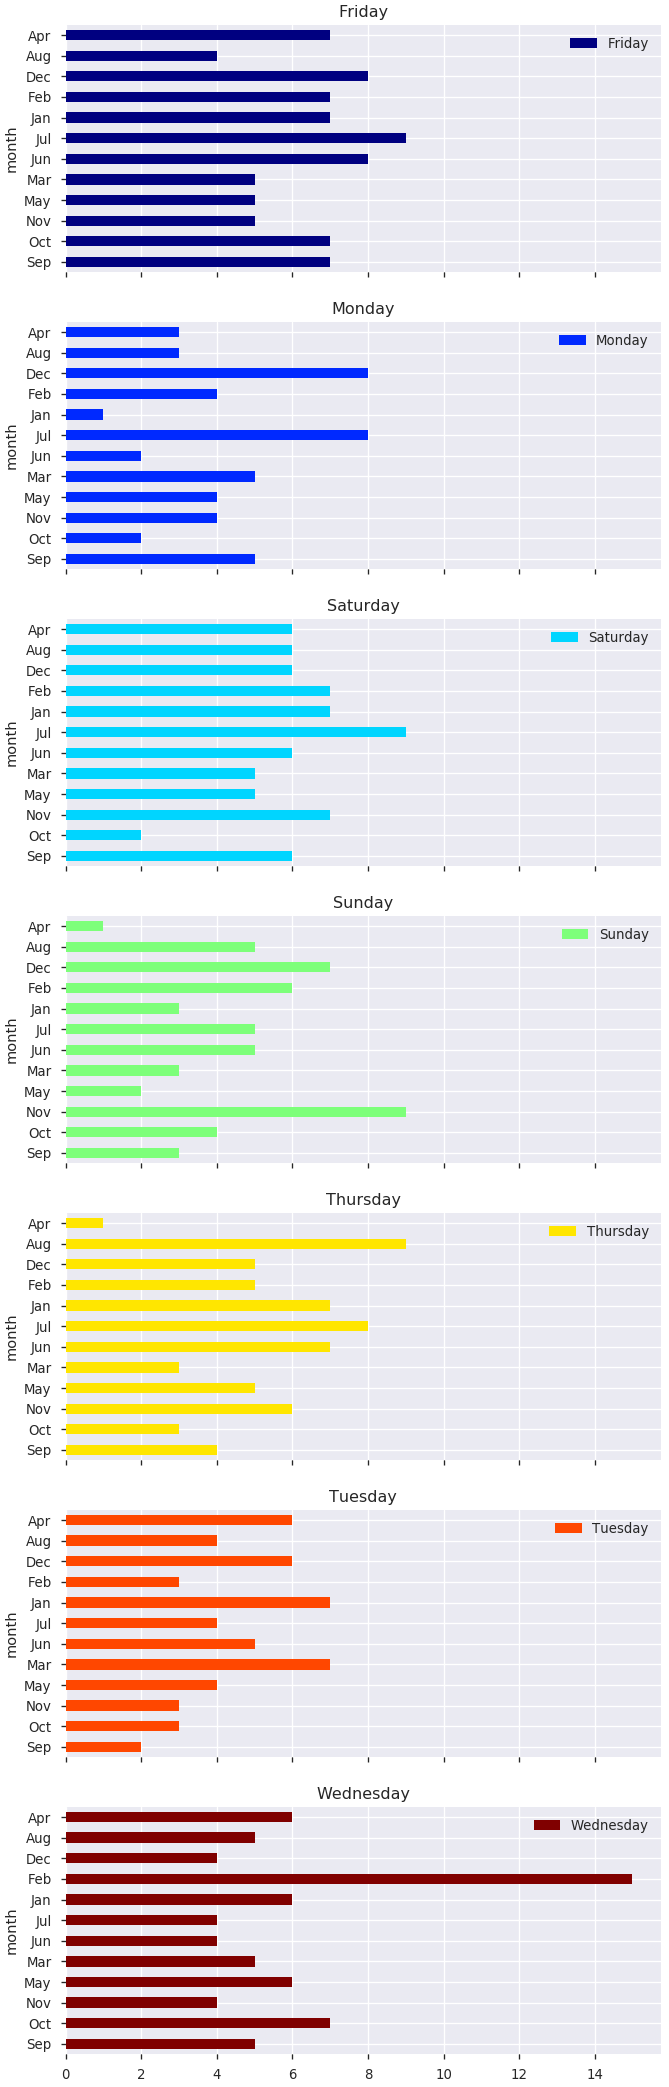

In [8]:
import pixiedust

display(sdf)

In [9]:
sdf.registerTempTable("crime_df") #set as temp table to enable SQL queries
crime_df = sqlContext.sql("SELECT * FROM crime_df WHERE month='Dec'")

In [10]:
crime_df.count()

44


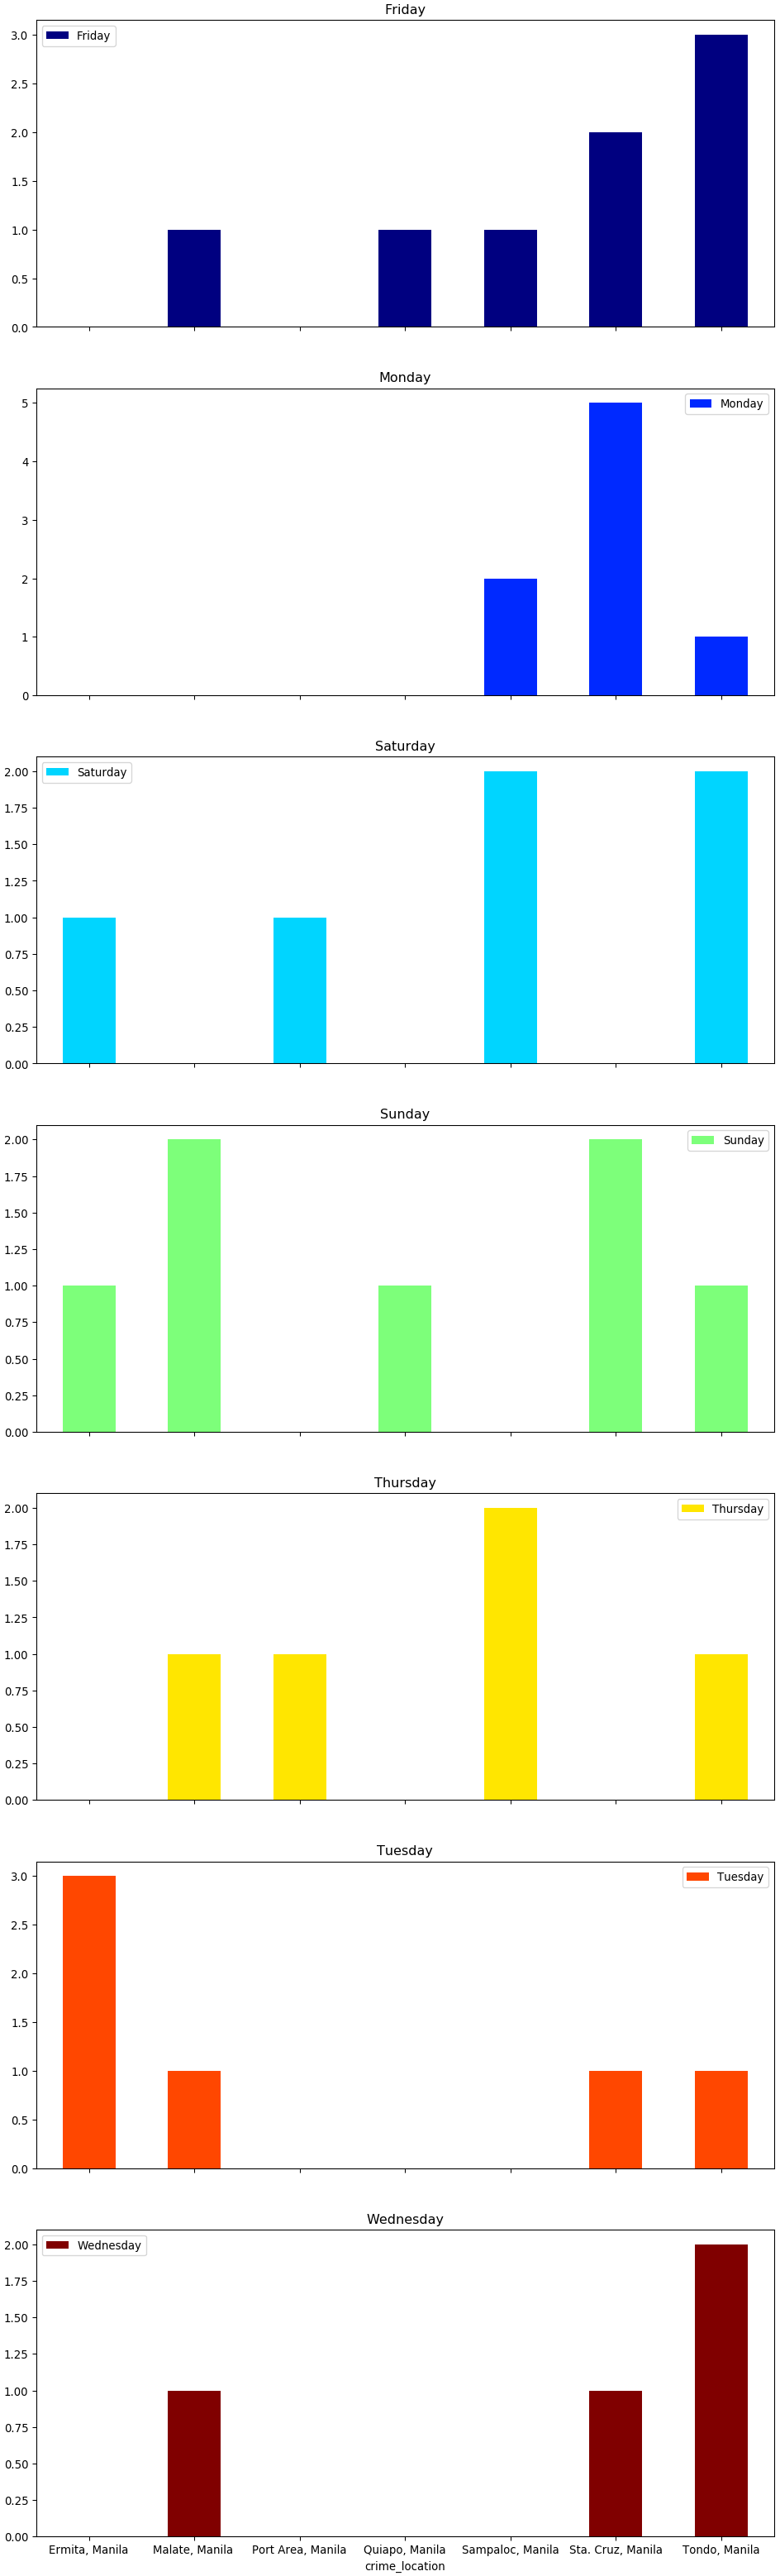

In [8]:
crime_df_agg = crime_df.groupby('time_range','crime_location','day_of_week').count()
display(crime_df_agg)

## Probabilistic Graphical Modeling

Bayesian Network implementation with 'pgmpy' package

In [11]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

#### Define network (model) structure

<img src="https://github.com/goodguynic/probabilistic_graphical_model/blob/master/BNmodel.jpg?raw=true" width="600"/>

In [12]:
#data_train = df_data.loc[:df_data.shape[0] , ['month', 'day_of_week', 'week_of_month', 'time_range', 'crime_location']]

model = BayesianModel([('month', 'day_of_week'),
                      ('week_of_month', 'day_of_week'),
                      ('time_range', 'crime_location'),
                      ('day_of_week', 'crime_location'),
                      ('crime_location', 'crime_against_property')])

#model.fit(data_train)

#### Define Conditional Probability Distribution of each node on our model structure

In [13]:
month_cpd = TabularCPD( variable = 'month',
                      variable_card = 12,
                      values = [[0.086168, 0.106576, 0.07483, 0.068027, 0.070295, 0.0839, 0.106576, 0.081633, 0.072562, 0.063492, 0.086168, 0.099773]])

In [14]:
week_cpd = TabularCPD( variable = 'week_of_month',
                     variable_card = 5,
                     values = [[0.185941, 0.283447, 0.226757, 0.235828, 0.068027]])

In [15]:
time_cpd = TabularCPD( variable = 'time_range',
                     variable_card = 8,
                     values = [[0.095238, 0.099773, 0.070295, 0.156463, 0.163265, 0.170068, 0.136054, 0.108844]])

In [16]:
loc_cpd = TabularCPD( variable = 'crime_location',
                    variable_card = 14,
                    values =[[0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.117647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.166667,0.000000,0.000000,0.285714,0.000000,0.100000,0.200000,0.142857,0.500000,0.000000,0.000000,0.285714,0.125000,0.333333,0.000000,0.000000,0.250000,0.000000,0.000000,0.375000,0.125000,0.444444,0.230769,0.200000,0.000000,0.125000,0.000000,0.363636,0.166667,0.058824,0.400000,0.300000,0.000000,0.000000,0.100000,0.333333,0.461538,0.000000,0.000000,0.222222,0.375000,0.000000,0.000000,0.071429,0.166667,0.058824,0.000000,0.000000,0.222222,0.200000,0.000000,0.230769,0.090909,0.083333,0.000000,0.375000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.500000,0.000000,0.285714,0.125000,0.000000,0.100000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.400000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.076923,0.600000,0.000000,0.000000,0.000000,0.272727,0.166667,0.117647,0.000000,0.300000,0.000000,0.333333,0.000000,0.111111,0.000000,0.000000,0.222222,0.222222,0.000000,0.111111,0.000000,0.071429,0.166667,0.058824,0.250000,0.250000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.125000],
                             [0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.111111,0.400000,0.000000,0.000000,0.000000,0.083333,0.000000,0.125000],
                             [0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.250000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.200000,0.000000,0.125000,0.125000,0.000000,0.153846,0.000000,0.400000,0.125000,0.000000,0.000000,0.083333,0.117647,0.000000,0.000000,0.333333,0.000000,0.200000,0.000000,0.076923,0.000000,0.000000,0.111111,0.125000,0.555556,0.142857,0.142857,0.000000,0.000000,0.125000,0.000000,0.111111,0.000000,0.333333,0.153846,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.100000,0.142857,0.000000,0.000000,0.000000,0.142857,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.058824,0.000000,0.100000,0.000000,0.000000,0.100000,0.111111,0.076923,0.000000,0.111111,0.111111,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.166667,0.076923,0.090909,0.000000,0.000000,0.125000],
                             [0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.285714,0.000000,0.000000,0.000000,0.000000,0.125000,0.125000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.200000,0.000000,0.000000,0.000000,0.200000,0.111111,0.076923,0.000000,0.222222,0.000000,0.125000,0.000000,0.142857,0.000000,0.083333,0.176471,0.125000,0.000000,0.000000,0.000000,0.166667,0.153846,0.181818,0.166667,0.125000,0.000000],
                             [0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.100000,0.111111,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.076923,0.000000,0.083333,0.125000,0.125000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.200000,0.000000,0.000000,0.125000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.100000,0.000000,0.333333,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.222222,0.000000,0.071429,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.166667,0.000000,0.000000],
                             [0.000000,0.000000,0.000000,0.142857,0.125000,0.500000,0.400000,0.142857,0.250000,0.500000,0.000000,0.571429,0.375000,0.000000,0.142857,0.400000,0.250000,0.200000,0.500000,0.000000,0.125000,0.111111,0.307692,0.000000,0.000000,0.125000,0.000000,0.000000,0.083333,0.294118,0.200000,0.200000,0.000000,0.333333,0.100000,0.222222,0.153846,0.250000,0.000000,0.111111,0.375000,0.111111,0.142857,0.142857,0.250000,0.235294,0.125000,0.000000,0.000000,0.200000,0.000000,0.153846,0.272727,0.333333,0.250000,0.125000],
                             [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000],
                             [0.333333,0.250000,0.000000,0.000000,0.625000,0.300000,0.100000,0.142857,0.000000,0.100000,0.000000,0.000000,0.500000,0.000000,0.285714,0.200000,0.000000,0.400000,0.000000,0.250000,0.375000,0.111111,0.230769,0.200000,0.400000,0.375000,0.000000,0.363636,0.333333,0.235294,0.200000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.250000,0.333333,0.222222,0.000000,0.000000,0.142857,0.285714,0.250000,0.352941,0.125000,0.500000,0.444444,0.200000,0.166667,0.153846,0.181818,0.083333,0.500000,0.000000]],
                    evidence = ['day_of_week', 'time_range'],
                    evidence_card = [7,8])

In [17]:
day_cpd = TabularCPD( variable = 'day_of_week',
                    variable_card = 7,
                    values =[[0.125000,0.000000,0.076923,0.090909,0.000000,0.200000,0.142857,0.090909,0.083333,0.142857,0.250000,0.066667,0.000000,0.250000,0.142857,0.000000,0.000000,0.166667,0.000000,0.142857,0.000000,0.100000,0.200000,0.000000,0.000000,0.100000,0.000000,0.333333,0.090909,0.142857,0.181818,0.083333,0.090909,0.125000,0.000000,0.000000,0.142857,0.166667,0.166667,0.142857,0.142857,0.000000,0.200000,0.083333,0.000000,0.142857,0.142857,0.000000,0.000000,0.285714,0.400000,0.153846,0.333333,0.125000,0.250000,0.166667,0.181818,0.250000,0.000000,0.125000],
                             [0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.214286,0.000000,0.083333,0.142857,0.250000,0.133333,0.200000,0.000000,0.142857,0.000000,0.083333,0.166667,0.111111,0.142857,0.000000,0.100000,0.200000,0.166667,0.000000,0.100000,0.000000,0.000000,0.090909,0.142857,0.090909,0.166667,0.090909,0.375000,0.200000,0.000000,0.071429,0.166667,0.000000,0.142857,0.000000,0.500000,0.000000,0.083333,0.500000,0.142857,0.142857,0.000000,0.000000,0.000000,0.100000,0.153846,0.333333,0.000000,0.000000,0.166667,0.090909,0.083333,0.285714,0.375000],
                             [0.250000,0.500000,0.153846,0.090909,0.000000,0.000000,0.071429,0.090909,0.083333,0.142857,0.000000,0.333333,0.200000,0.000000,0.142857,0.666667,0.083333,0.166667,0.222222,0.142857,0.000000,0.200000,0.200000,0.083333,0.000000,0.300000,0.000000,0.000000,0.181818,0.142857,0.000000,0.166667,0.000000,0.125000,0.200000,0.250000,0.142857,0.083333,0.000000,0.142857,0.000000,0.166667,0.000000,0.083333,0.000000,0.142857,0.000000,0.000000,0.250000,0.142857,0.000000,0.076923,0.000000,0.125000,0.250000,0.000000,0.272727,0.166667,0.142857,0.000000],
                             [0.125000,0.000000,0.153846,0.272727,0.000000,0.300000,0.285714,0.272727,0.416667,0.142857,0.000000,0.200000,0.100000,0.250000,0.142857,0.333333,0.166667,0.166667,0.222222,0.142857,0.500000,0.100000,0.000000,0.250000,0.500000,0.200000,0.000000,0.111111,0.090909,0.142857,0.090909,0.166667,0.000000,0.125000,0.000000,0.250000,0.214286,0.083333,0.000000,0.142857,0.285714,0.000000,0.400000,0.083333,0.000000,0.142857,0.285714,0.000000,0.250000,0.428571,0.100000,0.153846,0.000000,0.125000,0.000000,0.166667,0.000000,0.083333,0.142857,0.125000],
                             [0.125000,0.000000,0.230769,0.181818,0.500000,0.000000,0.214286,0.181818,0.000000,0.142857,0.500000,0.066667,0.000000,0.000000,0.142857,0.000000,0.083333,0.000000,0.000000,0.142857,0.000000,0.200000,0.200000,0.166667,0.000000,0.200000,0.285714,0.111111,0.181818,0.142857,0.090909,0.083333,0.363636,0.000000,0.400000,0.250000,0.142857,0.250000,0.500000,0.142857,0.000000,0.333333,0.000000,0.083333,0.500000,0.142857,0.142857,0.000000,0.000000,0.142857,0.200000,0.153846,0.000000,0.125000,0.250000,0.000000,0.181818,0.166667,0.142857,0.000000],
                             [0.125000,0.250000,0.153846,0.181818,0.500000,0.100000,0.071429,0.272727,0.166667,0.142857,0.000000,0.200000,0.200000,0.000000,0.142857,0.000000,0.250000,0.166667,0.333333,0.142857,0.000000,0.200000,0.000000,0.166667,0.500000,0.100000,0.428571,0.111111,0.272727,0.142857,0.090909,0.166667,0.272727,0.250000,0.200000,0.000000,0.071429,0.166667,0.166667,0.142857,0.285714,0.000000,0.000000,0.416667,0.000000,0.285714,0.142857,1.000000,0.250000,0.000000,0.100000,0.153846,0.000000,0.125000,0.250000,0.500000,0.090909,0.166667,0.142857,0.125000],
                             [0.250000,0.250000,0.153846,0.181818,0.000000,0.400000,0.000000,0.090909,0.166667,0.142857,0.000000,0.000000,0.300000,0.500000,0.142857,0.000000,0.333333,0.166667,0.111111,0.142857,0.500000,0.100000,0.200000,0.166667,0.000000,0.000000,0.285714,0.333333,0.090909,0.142857,0.454545,0.166667,0.181818,0.000000,0.000000,0.250000,0.214286,0.083333,0.166667,0.142857,0.285714,0.000000,0.400000,0.166667,0.000000,0.000000,0.142857,0.000000,0.250000,0.000000,0.100000,0.153846,0.333333,0.375000,0.000000,0.000000,0.181818,0.083333,0.142857,0.250000]],
                    evidence = ['month', 'week_of_month'],
                    evidence_card = [12, 5])

In [18]:
crime_cpd = TabularCPD( variable = 'crime_against_property',
                      variable_card = 2,
                      values =[[0.000539,0.006652,0.000842,0.000525,0.000188,0.000487,0.000075,0.000864,0.000084,0.000103,0.000084,0.000699,0.000045,0.000146],
                               [0.999461,0.993348,0.999158,0.999475,0.999812,0.999513,0.999925,0.999136,0.999916,0.999897,0.999916,0.999301,0.999955,0.999854]],
                      evidence = ['crime_location'],
                      evidence_card = [14])

##### Add relationships to our model

In [19]:
model.add_cpds(month_cpd, week_cpd, time_cpd, loc_cpd, day_cpd, crime_cpd)

##### Check validity of model

In [20]:
model.check_model()

True

##### Examine structure of model

In [21]:
model.get_cpds()

[<TabularCPD representing P(month:12) at 0x7f08468feba8>,
 <TabularCPD representing P(week_of_month:5) at 0x7f08468fe9e8>,
 <TabularCPD representing P(time_range:8) at 0x7f08468feb70>,
 <TabularCPD representing P(crime_location:14 | day_of_week:7, time_range:8) at 0x7f0846928908>,
 <TabularCPD representing P(day_of_week:7 | month:12, week_of_month:5) at 0x7f0846916828>,
 <TabularCPD representing P(crime_against_property:2 | crime_location:14) at 0x7f08469283c8>]

##### Examine chained nodes

In [22]:
model.active_trail_nodes('crime_against_property')

{'crime_against_property': {'crime_against_property',
  'crime_location',
  'day_of_week',
  'month',
  'time_range',
  'week_of_month'}}

##### Examine independencies

In [23]:
#local independencies
model.local_independencies('crime_location')

(crime_location _|_ month, week_of_month | time_range, day_of_week)

In [24]:
#All independencies
model.get_independencies()

(month _|_ time_range, week_of_month)
(month _|_ week_of_month | time_range)
(month _|_ time_range | week_of_month)
(month _|_ crime_against_property | crime_location)
(month _|_ crime_against_property, time_range, crime_location | day_of_week)
(month _|_ crime_against_property | time_range, crime_location)
(month _|_ crime_against_property, crime_location | time_range, day_of_week)
(month _|_ time_range, crime_location | crime_against_property, day_of_week)
(month _|_ crime_against_property | week_of_month, crime_location)
(month _|_ crime_against_property, time_range, crime_location | week_of_month, day_of_week)
(month _|_ crime_against_property, time_range | crime_location, day_of_week)
(month _|_ crime_location | crime_against_property, time_range, day_of_week)
(month _|_ crime_against_property | time_range, crime_location, week_of_month)
(month _|_ crime_against_property, crime_location | day_of_week, time_range, week_of_month)
(month _|_ crime_against_property | time_range, crime

## Making Inference

Solve for conditional or marginal probability distribution of a variable. 
Upstream or downstream logic is possible

In [25]:
from pgmpy.inference import VariableElimination

model_ = VariableElimination(model)

##### Variable dictionary

In [37]:
#define dictionary for variables for output intuition
dict_master = {'month':{0:'January', 1:'February', 2:'March', 3:'April', 4:'May', 5:'June', 6:'July', 7:'August', 8:'September', 9:'October', 10:'November', 11:'December'},
              'week_of_month':{0:'1st week', 1:'2nd week', 2:'3rd week', 3:'4th week', 4:'5th week'},
              'day_of_week':{0:'Sunday', 1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday'},
              'time_range':{0:'12AM-3AM', 1:'3AM-6AM', 2:'6AM-9AM', 3:'9AM-12PM', 4:'12PM-3PM', 5:'3PM-6PM', 6:'6PM-9PM', 7:'9PM-12AM'},
              'crime_location':{0:'Binondo', 1:'Ermita', 2:'Intramuros', 3:'Malate', 4:'Paco', 5:'Pandacan', 6:'Port Area', 7:'Quiapo', 8:'Sampaloc', 9:'San Andres', 10:'Sta. Ana', 11:'Sta. Cruz', 12:'Sta. Mesa', 13:'Tondo'},
              'crime_against_property':{0:'Robbery and/or Theft happens', 1:'Robbery and/or Theft did not happen'}}

### Function definitions

In [38]:
# infer probability distribution of variables
def infer_prob__dist(variables_, evidence_ = None):
    """ Prints probability density of given variables_ with respect to conditions as evidence_ """
    """ variables_ is a list of strings | evidence_ is a list of tuples with first element = model structure and """
    """ second element = integer with range of the corresponding model structure { e.g '[(mode1, 3),(node2, 6)] } """
    
    condition = 'No conditions'
    if evidence_ != None:
        evidence_ = dict(evidence_)
        result = model_.query(variables = variables_, evidence = evidence_)
        condition = ''
        for e in evidence_:
            dict_pointer = dict_master[e][evidence_[e]]
            #print(dict_pointer)
            condition += (e+' = '+dict_pointer+'   ')
        
    elif evidence_ == None:
        result = model_.query(variables = variables_)
        
    for i in variables_:
        string = '\n'
        for loc in dict_master[i]:
            string += (i+'_'+str(loc)+' - '+dict_master[i][loc]+'\n')
        print(string, result[i])

    return ('Given:  '+condition)

In [39]:
#get most probable state of a variable
def infer_most_probable(variables_, evidence_ = None):
    """ Prints most probable state of given variables_ with respect to conditions as evidence_ """
    """ variables_ is a list of string | evidence_ is a list of tuples with first element = model structure and """
    """ second element = integer with range of the corresponding model structure { e.g '[(mode1, 3),(node2, 6)] } """
    
    condition = 'No conditions'
    if evidence_ != None:
        evidence_ = dict(evidence_)
        result = model_.map_query(variables = variables_, evidence = evidence_)
        condition = ''
        for e in evidence_:
            dict_pointer = dict_master[e][evidence_[e]]
            #print(dict_pointer)
            condition += (e+' = '+dict_pointer+'   ')
        
    elif evidence_ == None:
        result = model_.map_query(variables = variables_)
        
    for i in variables_:
        string = '\n'
        for loc in dict_master[i]:
            string += (i+'_'+str(loc)+' - '+dict_master[i][loc]+'\n')
        print('Most probable state of ',i,' is ', dict_master[i][result[i]])

    return ('Given:  '+condition)

### Inference

Note: phi is the probability density of the standard Gaussian distribution (standard normal distribution with zero mean and unit variance)

##### infer probability distribution of variables

In [46]:
x = ['crime_location']
y = [('month', 1), ('week_of_month', 4), ('day_of_week', 0), ('time_range', 4), ('crime_against_property', 0)]
infer_prob__dist(x, y)


crime_location_0 - Binondo
crime_location_1 - Ermita
crime_location_2 - Intramuros
crime_location_3 - Malate
crime_location_4 - Paco
crime_location_5 - Pandacan
crime_location_6 - Port Area
crime_location_7 - Quiapo
crime_location_8 - Sampaloc
crime_location_9 - San Andres
crime_location_10 - Sta. Ana
crime_location_11 - Sta. Cruz
crime_location_12 - Sta. Mesa
crime_location_13 - Tondo
 +-------------------+-----------------------+
| crime_location    |   phi(crime_location) |
+===================+=======================+
| crime_location_0  |                0.0000 |
+-------------------+-----------------------+
| crime_location_1  |                0.0000 |
+-------------------+-----------------------+
| crime_location_2  |                0.0000 |
+-------------------+-----------------------+
| crime_location_3  |                0.1863 |
+-------------------+-----------------------+
| crime_location_4  |                0.0000 |
+-------------------+-----------------------+
| crime_loc

'Given:  month = February   week_of_month = 5th week   day_of_week = Sunday   time_range = 12PM-3PM   crime_against_property = Robbery and/or Theft happens   '

##### get most probable state of a variable

In [54]:
x = ['crime_location']
y = [('month', 0), ('week_of_month', 0), ('day_of_week', 4), ('time_range', 7), ('crime_against_property', 0)]
infer_most_probable(x,y)

Most probable state of  crime_location  is  Ermita


'Given:  month = January   week_of_month = 1st week   day_of_week = Thursday   time_range = 9PM-12AM   crime_against_property = Robbery and/or Theft happens   '